In [1]:
!pip install opendatasets -q

In [2]:
import opendatasets as od
import pandas

Create your Kaggle API to have a json file with username and key and enter below. Or you can download and extract manually from:  https://www.kaggle.com/competitions/titanic/data

In [ ]:
od.download("https://www.kaggle.com/competitions/titanic/data")

In [5]:
import os
os.chdir('titanic')
os.listdir()

['train.csv', 'gender_submission.csv', 'test.csv']

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
df = pd.read_csv('train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [44]:
class NaiveBayesClassifier:
    def __init__(self, df, categorical_features, continuous_features, class_feature):
        self.df = df
        self.categorical_features = categorical_features
        self.continuous_features = continuous_features
        self.class_feature = class_feature
        self.prior = {}
        self.likelihood_categorical = {}
        self.likelihood_continuous = {}
        self.class_labels = df[class_feature].unique()

    def calculate_prior(self):
        class_counts = self.df[self.class_feature].value_counts()
        total_count = len(self.df)
        self.prior = {label: class_counts[label] / total_count for label in self.class_labels}
        print("Prior probabilities:", self.prior)

    def calculate_likelihood_categorical(self):
        for feature in self.categorical_features:
            likelihood = {}
            for label in self.class_labels:
                likelihood[label] = self.df[self.df[self.class_feature] == label][feature].value_counts(normalize=True).to_dict()
            self.likelihood_categorical[feature] = likelihood

        # Display likelihood tables for categorical features
        print("\nLikelihood tables for CATEGORICAL features")
        for feature, likelihood in self.likelihood_categorical.items():
            print("\nFeature: {}".format(feature))
            display(pd.DataFrame(likelihood).fillna(0))

    def calculate_likelihood_continuous(self):
        for feature in self.continuous_features:
            likelihood = {}
            for label in self.class_labels:
                subset = self.df[self.df[self.class_feature] == label][feature]
                likelihood[label] = {'mean': subset.mean(), 'std': subset.std()}
            self.likelihood_continuous[feature] = likelihood

        # Display likelihood tables for continuous features
        print("\nLikelihood tables for CONTINUOUS features")
        for feature, likelihood in self.likelihood_continuous.items():
            print("\nFeature: {}".format(feature))
            display(pd.DataFrame(likelihood))

    def gaussian_probability(self, x, mean, std):
        exponent = np.exp(-((x - mean) ** 2 / (2 * std ** 2)))
        return (1 / (np.sqrt(2 * np.pi) * std)) * exponent

    def calculate_posterior(self, row):
        posteriors = {}
        for label in self.class_labels:
            prior = np.log(self.prior[label])
            likelihood = 0

            for feature in self.categorical_features:
                value = row[feature]
                if value in self.likelihood_categorical[feature][label]:
                    likelihood += np.log(self.likelihood_categorical[feature][label][value])
                else:
                    likelihood += np.log(1e-6)  # Small value to handle unknown categories

            for feature in self.continuous_features:
                value = row[feature]
                mean = self.likelihood_continuous[feature][label]['mean']
                std = self.likelihood_continuous[feature][label]['std']
                likelihood += np.log(self.gaussian_probability(value, mean, std))

            posteriors[label] = prior + likelihood

        return posteriors

    def predict(self, X):
        predictions = []
        for _, row in X.iterrows():
            posteriors = self.calculate_posterior(row)
            predictions.append(max(posteriors, key=posteriors.get))
        return predictions

    def train(self):
        self.calculate_prior()
        self.calculate_likelihood_categorical()
        self.calculate_likelihood_continuous()

    def evaluate(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        print(f'Accuracy: {accuracy * 100:.2f}%')
        return predictions, accuracy

In [45]:
# Define features
categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
continuous_features = ['Age', 'Fare']
class_feature = 'Survived'

# Drop rows with missing values in features we're using
df = df.dropna(subset=categorical_features + continuous_features)

In [46]:
# Split data into training and testing (80% train, 20% test)
train_df = df.sample(frac=0.8, random_state=42)

test_df = df.drop(train_df.index)
X_test = test_df.drop(columns=[class_feature])
y_test = test_df[class_feature]

In [47]:
# Train the model
nb = NaiveBayesClassifier(train_df, categorical_features, continuous_features, class_feature)
nb.train()

Prior probabilities: {1: 0.4017543859649123, 0: 0.5982456140350877}

Likelihood tables for CATEGORICAL features

Feature: Pclass


,1,0
1,0.393013,0.155425
2,0.314410,0.205279
3,0.292576,0.639296



Feature: Sex


,1,0
female,0.703057,0.16129
male,0.296943,0.83871



Feature: SibSp


,1,0
0,0.615721,0.700880
1,0.327511,0.190616
2,0.039301,0.035191
4,0.008734,0.043988
3,0.008734,0.017595
5,0.000000,0.011730



Feature: Parch


,1,0
0,0.620087,0.777126
1,0.231441,0.117302
2,0.131004,0.076246
3,0.013100,0.005865
5,0.004367,0.008798
4,0.000000,0.011730
6,0.000000,0.002933



Feature: Embarked


,1,0
S,0.685590,0.826979
C,0.288210,0.114370
Q,0.026201,0.058651



Likelihood tables for CONTINUOUS features

Feature: Age


,1,0
mean,28.080786,30.489736
std,15.178497,14.217296



Feature: Fare


,1,0
mean,51.424110,24.126819
std,73.936729,33.964202


In [48]:
# Evaluate the model
predictions, accuracy = nb.evaluate(X_test, y_test)

Accuracy: 72.54%


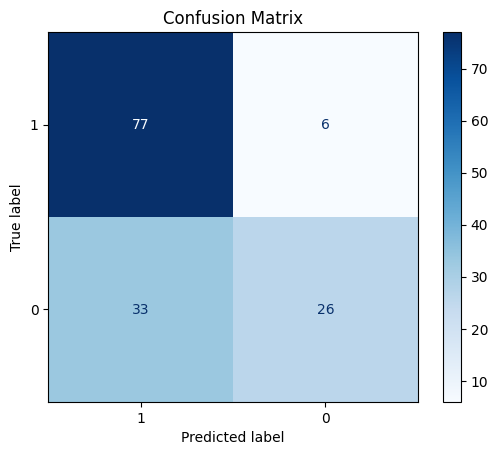

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [50]:
# Calculate and display additional metrics
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    negative_predictive_value = TN / (TN + FN) if (TN + FN) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metrics = {
        'Accuracy': accuracy,
        'Precision (PPV)': precision,
        'Negative Predictive Value (NPV)': negative_predictive_value,
        'Recall (Sensitivity)': recall,
        'Specificity': specificity,
        'F1 Score': f1_score
    }

    return metrics

metrics = calculate_metrics(y_test, predictions)

# Display the metrics
print("Model Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Model Evaluation Metrics:
Accuracy: 0.7254
Precision (PPV): 0.8125
Negative Predictive Value (NPV): 0.7000
Recall (Sensitivity): 0.4407
Specificity: 0.9277
F1 Score: 0.5714


In [51]:
# Create a DataFrame to display ground truth and predicted values along with test features
results_df = X_test.copy()
results_df['Ground Truth'] = y_test.values
results_df['Predicted'] = predictions

# Reorder columns to show 'Ground Truth' and 'Predicted' first
cols = ['Ground Truth', 'Predicted'] + [col for col in results_df.columns if col not in ['Ground Truth', 'Predicted']]
results_df = results_df[cols]

# Display the resulting DataFrame
display(results_df)

,Ground Truth,Predicted,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,1,1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
4,0,0,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
14,0,0,15,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S
15,1,0,16,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
23,1,0,24,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,1,1,872,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
872,0,0,873,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S
877,0,0,878,3,"Petroff, Mr. Nedelio",male,19.0,0,0,349212,7.8958,NaN,S
883,0,0,884,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
